### Bayesian Personalized Ranking from Implicit Feedback
- https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf
### Weighted Approximate-Rank Pairwise
- https://making.lyst.com/lightfm/docs/examples/warp_loss.html
- http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [3]:
SEED = 42
np.random.seed(SEED)

## Analyse Dataset

### Amazon product review   Dataset
- https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews?resource=download

In [4]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!gdown https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb

Downloading...
From: https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb
To: /content/ratings_Electronics.csv
100% 319M/319M [00:02<00:00, 141MB/s]


#### Consider movies rated by more than 30 users

In [6]:
rating_df =pd.read_csv('ratings_Electronics.csv',  names=['userID','itemID','rating','time'])
rating_df=rating_df[['userID','itemID','rating','time']]

x = rating_df.groupby('userID').count()['rating'] >= 30
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['userID'].isin(userIndex)]
y = nm_rating_df.groupby('itemID').count()['rating']>=30
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['itemID'].isin(items)]
rating_df.shape

(51702, 4)

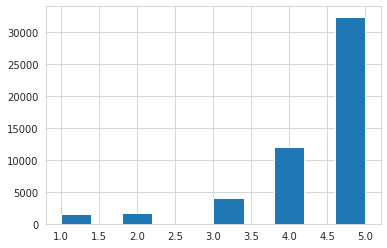

In [7]:
rating_df['rating'].hist()

In [8]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [9]:
rating_df['userID'] = rating_df.userID.apply(lambda u: user_ids[u])
rating_df['itemID'] = rating_df.itemID.apply(lambda m: item_ids[m])

### LightFM

In [10]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k 
from lightfm.evaluation import recall_at_k 

### Prepare train test set

In [12]:
dataset = Dataset()

In [13]:
dataset.fit(users=rating_df['userID'], 
            items=rating_df['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 5176, num_topics: 919.


In [14]:
rating_df.iloc[:, :3]

,userID,itemID,rating
22141,0,0,4.0
22222,1,0,5.0
22256,2,0,5.0
22282,3,0,5.0
22287,4,0,5.0
...,...,...,...
7820346,2816,918,4.0
7820356,4152,918,5.0
7820367,4667,918,5.0
7820380,1358,918,3.0


In [15]:
(interactions, weights) = dataset.build_interactions(rating_df.iloc[:, 0:3].values)


In [16]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=.2,
    random_state=np.random.RandomState(SEED))

In [17]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (5176, 919)
Shape of test interactions: (5176, 919)


In [18]:

# Number of recommendations
K = 10
# model learning rate
LR = 0.25
# no of latent factors
NO_COMPONENTS = 20

# no of threads to fit model
THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6


In [19]:

warp_model = LightFM(no_components=NO_COMPONENTS,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=USER_ALPHA,
                    item_alpha=ITEM_ALPHA)

bpr_model = LightFM(no_components=NO_COMPONENTS,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=USER_ALPHA,
                    item_alpha=ITEM_ALPHA)

In [20]:
from lightfm.evaluation import auc_score
warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []
import time
# no of epochs to fit model
epochs = 20
for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train_interactions, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test_interactions, train_interactions=train_interactions).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train_interactions, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test_interactions, train_interactions=train_interactions).mean())

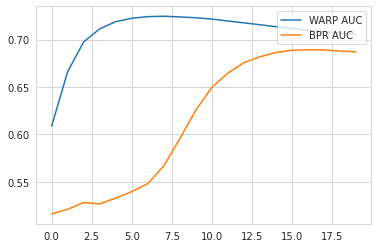

In [21]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

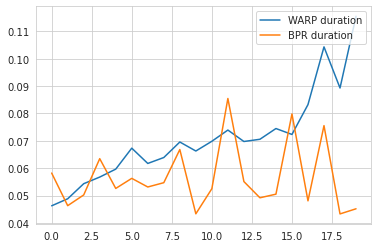

In [22]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

In [23]:
print("Train precision: %.2f" % precision_at_k(bpr_model, train_interactions, k=10).mean())
print("Test precision: %.2f" % precision_at_k(bpr_model, test_interactions, k=10).mean())

Train precision: 0.19
Test precision: 0.01


In [24]:
print("Train precision: %.2f" % precision_at_k(warp_model, train_interactions, k=10).mean())
print("Test precision: %.2f" % precision_at_k(warp_model, test_interactions, k=10).mean())

Train precision: 0.27
Test precision: 0.01


In [25]:
n_users, n_items = test_interactions.shape

In [26]:
testuserid=0

In [33]:
rating_df

,userID,itemID,rating,time
22141,0,0,4.0,1105747200
22222,1,0,5.0,1339545600
22256,2,0,5.0,1156982400
22282,3,0,5.0,1220313600
22287,4,0,5.0,1346630400
...,...,...,...,...
7820346,2816,918,4.0,1404086400
7820356,4152,918,5.0,1405814400
7820367,4667,918,5.0,1403481600
7820380,1358,918,3.0,1404172800


In [34]:
listofalreadyavailableitrems=list(rating_df[rating_df['userID']==testuserid].itemID.values)
unique_items_list=list( rating_df.itemID.unique())
itemsnotexplored=main_list = list(set(unique_items_list) - set( listofalreadyavailableitrems))
itemsnotexplored=np.array(itemsnotexplored)

In [35]:
items=itemsnotexplored.shape[0]
userarray=np.empty(items)
userarray.fill(testuserid)

In [36]:
score=bpr_model.predict(userarray,
                      itemsnotexplored
                     )

In [38]:
ind=score.argsort()[-10:][::-1]
ind

array([302,  10,  33, 311, 109, 236, 493,  53, 287, 597])